In [1]:
# https://github.com/pochih/FCN-pytorch/blob/master/python/fcn.py
from torchvision.models import vgg16
from Utilities.FCN.myFcn import my_fcn_resnet50

# Custom functionalities
from Utilities.classHandler import CityscapesClass
from Utilities.datasetHandler import CityscapesDataset, visualise_and_save
from Utilities.modelHandler import modelFCN
from Utilities.metrics import meanPixelwiseAccuracy, meanIoU
from Utilities.customLoss import DiceLoss
from Utilities.myModel import modelConstructor

import os
import time
import torch
import torch.nn.functional as F
from torchvision.io.image import read_image
from torchvision.transforms.functional import to_pil_image
from torch.utils.data import DataLoader
from torch import nn
from torchvision.models import ResNet50_Weights
from torchvision.models.segmentation import fcn_resnet50, FCN_ResNet50_Weights
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torchvision.utils import draw_segmentation_masks
import matplotlib.pyplot as plt

device = torch.device('cpu')
if torch.cuda.is_available(): device = torch.device('cuda')

torch.cuda.empty_cache()

#plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 17

import numpy as np
import torch

def meanPixelwiseAccuracy(pred, gt):
    '''
    Compute the mean pixelwise accuracy averaged across one batch
    pred dimensions: B x W x H
    gt dimensions: B x C x W x H
    
    PAk = sum( True positives for class k) / (H x W) 
    
    mPA = sum(PAk) / k  --> average on the classes
    
    '''
    
    num_classes = gt.size(1)
    batch_size = pred.size(0)
    
    gt = gt.argmax(dim=1)

    acc = np.zeros((num_classes, batch_size)) # k: channels, B: batches

    check = 0
    
    for idx, p in enumerate(pred): # loop on the batch
        # p and yy have dimensions: 1 x H x W
        yy = gt[idx]   

        for k in range(num_classes):
            TP = torch.logical_and((p==k), (yy==k)).sum().item() # True positives in the k-th class
            check += TP
            acc[k, idx] = TP / (p.size(0)*p.size(1))

        print(check)
        acc_per_channel = list(np.mean(acc, axis = 1)) # take the mean across batches to have the accuracy per channel

        mPA = np.mean(np.mean(acc, axis = 0)) # take the mean across channels to have the accuracy per batch, then take the mean for the meanPixelwiseAccuracy

    return mPA, acc_per_channel       
    

def meanIoU(pred, gt):
    '''
    Compute the mean Intersection over Union across one batch
    pred dimensions: B x W x H
    gt dimensions: B x C x W x H
    
    IoUk = pred *intersection* gt  / pred *union* gt
    
    mIoU = sum(IoUk) / k  --> average on the classes
    
    '''
    
    num_classes = gt.size(1)
    batch_size = pred.size(0)
    
    gt = gt.argmax(dim=1)

    iou = np.zeros((num_classes, batch_size)) # k: channels, B: batches
 
    for idx, p in enumerate(pred): # loop on the batch
        # p and yy have dimensions: 1 x H x W
        yy = gt[idx]   
        
        for k in range(num_classes):   
            intersection = torch.logical_and((p==k), (yy==k)).sum().item() # pred *intersection* gt in the k-th class
            union = torch.logical_or((p==k), (yy==k)).sum().item() # pred *union* gt in the k-th class
            
            if union != 0:
                iou[k, idx] = intersection / union   
            else:
                iou[k, idx] = 1 # OPPURE 0
                
        iou_per_channel = list(np.mean(iou, axis = 1)) # take the mean across batches to have the IoU per channel

        mIoU = np.mean(np.mean(iou, axis = 0)) # take the mean across channels to have the IoU per batch, then take the mean for the meanIoU

    return mIoU, iou_per_channel       

In [56]:
import numpy as np
import torch

def meanPixelwiseAccuracy(pred, gt):
    '''
    Compute the mean pixelwise accuracy averaged across one batch
    pred dimensions: B x W x H
    gt dimensions: B x C x W x H
    
    PAk = sum( True positives for class k) / (H x W) 
    
    mPA = sum(PAk) / k  --> average on the classes
    
    '''
    
    num_classes = gt.size(1)
    batch_size = pred.size(0)
    
    gt = gt.argmax(dim=1)
    
    acc = np.zeros((num_classes, batch_size)) # k: channels, B: batches
    
    for idx, p in enumerate(pred): # loop on the batch
        # p and yy have dimensions: 1 x H x W
        yy = gt[idx]   

        for k in range(num_classes):
            TP = torch.logical_and((p==k), (yy==k)).sum().item() # True positives in the k-th class
            denum = (yy==k).sum().item()
            
            if denum == 0:
                if TP == 0:  
                    acc[k, idx] = 1
                else:
                    acc[k, idx] = 0
            else:
                acc[k, idx] = TP / denum

        acc_per_channel = list(np.mean(acc, axis = 1)) # take the mean across batches to have the accuracy per channel

        mPA = np.mean(np.mean(acc, axis = 0)) # take the mean across channels to have the accuracy per batch, then take the mean for the meanPixelwiseAccuracy

    return mPA, acc_per_channel       
    

def meanIoU(pred, gt):
    '''
    Compute the mean Intersection over Union across one batch
    pred dimensions: B x W x H
    gt dimensions: B x C x W x H
    
    IoUk = pred *intersection* gt  / pred *union* gt
    
    mIoU = sum(IoUk) / k  --> average on the classes
    
    '''
    
    num_classes = gt.size(1)
    batch_size = pred.size(0)
    
    gt = gt.argmax(dim=1)

    iou = np.zeros((num_classes, batch_size)) # k: channels, B: batches
 
    for idx, p in enumerate(pred): # loop on the batch
        # p and yy have dimensions: 1 x H x W
        yy = gt[idx]   
        
        for k in range(num_classes):   
            intersection = torch.logical_and((p==k), (yy==k)).sum().item() # pred *intersection* gt in the k-th class
            union = torch.logical_or((p==k), (yy==k)).sum().item() # pred *union* gt in the k-th class
            
            if union != 0:
                iou[k, idx] = intersection / union   
            else:
                iou[k, idx] = 1 # OPPURE 0
                
        iou_per_channel = list(np.mean(iou, axis = 1)) # take the mean across batches to have the IoU per channel

        mIoU = np.mean(np.mean(iou, axis = 0)) # take the mean across channels to have the IoU per batch, then take the mean for the meanIoU

    return mIoU, iou_per_channel       

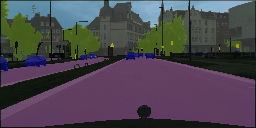

In [57]:
### DATASET ###
classes = CityscapesClass("10 classes") # Pick a case: "4 classes", "6 classes", "10 classes"

img_directory = '/mnt/data/course/psarin/inm705/leftImg8bit'
ground_truth_directory = '/mnt/data/course/psarin/inm705/gtFine_trainvaltest/gtFine'
n_classes = len(classes.labels) 
resize_dimensions = (128, 256)#(205,410)

dataset_args = {'image_directory' : img_directory,
                'gt_directory' : ground_truth_directory,
                'trainId' : classes.trainId,
                'colors' : classes.colors,
                'num_classes' : n_classes,
                'resize_dimensions' : resize_dimensions}

# Import datasets
dt_train = CityscapesDataset(phase = 'train', **dataset_args)


## TRAIN dataset
trainloader = DataLoader(dt_train, batch_size=1)

# Check dataset
X_viz, X_viz_norm = dt_train.get_image_visualization(1)
gt_mask = dt_train.get_ground_truth(1)
gt_mask = gt_mask.argmax(dim=0)

bool_masks = gt_mask == torch.arange(n_classes)[:, None, None]

sm = draw_segmentation_masks(X_viz, masks=bool_masks, alpha=0.6, colors = dt_train.colors)
to_pil_image(sm)

In [58]:
gt_mask.unique()

tensor([0, 1, 2, 3, 4, 5, 7])

In [34]:
## INITIALISE EXPERIMENT ##
exp_name = "fcn_res_yes"

## Models paramaters
total_epochs      = 30
save_every_epochs = 6 
learning_rate     = 1e-3
w_decay           = 1e-3


##MODEL Pretrained with RESNET 50
#Initialize model with the best available weights
FCN_weights = FCN_ResNet50_Weights.DEFAULT
backbone_weights = ResNet50_Weights.DEFAULT
model = my_fcn_resnet50(backbone_weights=backbone_weights).to(device)
#model = my_fcn_resnet50().to(device)

model.backbone.requires_grad_(False)
model.classifier[4] = nn.Conv2d(512, n_classes, kernel_size=(1, 1), stride=(1, 1))
model.classifier.requires_grad_(True)

cel = CrossEntropyLoss()
ad = Adam(model.parameters(), lr = learning_rate, weight_decay = w_decay)

fcn1 = modelFCN(model, loss_function=cel, optimizer = ad )
fcn1.model.to(device);

In [5]:
mPA, PAk, mIoU, IoUk = fcn1.evaluate_model(next(iter(trainloader)),'Checkpoints/fcn_res_yes/fcn_res_yes_30.pth')

In [35]:
i,x,y = next(iter(trainloader))

In [36]:
y.size()

torch.Size([1, 10, 128, 256])

In [37]:
y.unique()

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [38]:
model.load_state_dict(torch.load('Checkpoints/fcn_res_yes/fcn_res_yes_30.pth'))
model.eval()
model.to(device);

In [39]:
from torch.nn.functional import softmax
pred = model(x.to(device))

# Apply softmax and threshold value
out = softmax(pred,dim=1)# > 0.5
#out = out.int()
out = torch.argmax(out, dim=1)

In [45]:
out.unique()

tensor([0, 1, 2, 4, 5, 7], device='cuda:0')

In [46]:
yy = torch.argmax(y, dim=1)
yy.unique()

tensor([0, 1, 2, 3, 4, 5, 6, 7, 9])

In [59]:
m,k = meanPixelwiseAccuracy(out.to(device),y.to(device))

In [54]:
y.unique()

tensor([0.0000, 0.2500, 0.5000, 0.7500, 1.0000])

In [60]:
m

0.5064158482435877

In [61]:
k

[0.8155602864331334,
 0.782315561066336,
 0.8995245641838352,
 0.0,
 0.7032389845345783,
 0.5437062937062938,
 0.0,
 0.31981279251170047,
 1.0,
 0.0]

In [62]:
sum(k)/10

0.5064158482435877

In [65]:
mm,kk = meanIoU(out.to(device),y.to(device))

In [66]:
mm

0.4283331000198286

In [67]:
sum(kk)/10

0.4283331000198286

In [68]:
kk

[0.4626701800614844,
 0.7716709983183,
 0.7509260892573646,
 0.0,
 0.5649320206282231,
 0.4325452016689847,
 0.0,
 0.30058651026392963,
 1.0,
 0.0]

In [63]:
import numpy as np

results_path = "."
def metrics_per_class(X, PA, IoU, results_path):  
    X_axis = np.arange(len(classes.labels))

    plt.bar(X_axis - 0.15, PA, 0.3,label = 'PA')
    plt.bar(X_axis + 0.15, IoU, 0.3,label = 'IoU')

    plt.xticks(X_axis, classes.labels)
    plt.xticks(rotation=90)
    #plt.xlabel("Lables")
    plt.ylabel("Metrics")
    plt.legend()
    plt.savefig(results_path+"/metrics_per_class.png")
    plt.show()

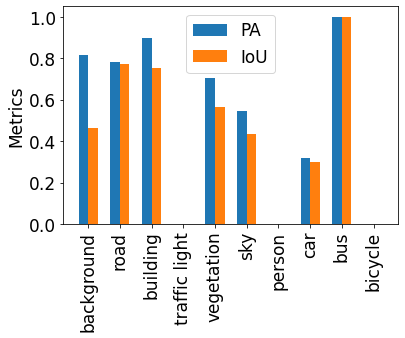

In [69]:
metrics_per_class(classes.labels, k, kk, ".")